# Mask Use, Total Population and Median Household Income

#### *Sources: Census Total Population, Census Median Household Income in the Past 12 Months and New York Times Mask Use*

##### This notebook contains code to:
* Connect to Census API
* Gather Census Total Population data
* Add a new column that combines state and county.  Split the NAME column into State Name and County Name columns
* Import New York Times Mask Use By County data
* Merge New York Times mask data to Census Total Population data
* Group data by State Name and state
* Calculate means for each state mask use
* Calculate population sum for each state  
* Reset the index
* Connect to the Covid Tracking Project API
* Create lists for Covid Tracking Project data and update Covid Tracking Project data with them
* Add lists to dictionary and create a dataframe from the dictionary
* Merge Covid Tracking Project data to NYT mask and census total population data
* Connect to Census API
* Gather Census Median Household Income in the Past 12 Months data
* Add a new column that combines state and county
* Split the NAME column into State Name and County Name columns
* Group median household income
* Merge median household Income with existing data
* Create a scatter plot of  mask use vs median household income

In [13]:
import pandas as pd
from census import Census #<-- Python wrapper for census API
import requests
import os
import matplotlib.pyplot as plt
import scipy.stats as sts
import numpy as np
import time

# Census API Key
from config import api_key

#### Connect to Census API
#### Gather Census Total Population data

In [14]:
# provide the api key and the year to establish a session
c = Census(api_key, year=2018)

# Set an option to allow up to 300 characters to print in each column
pd.set_option('max_colwidth', 300)

tables = c.acs5.tables()

# The tables variable contains a list of dicts, so we can convert directly to a dataframe
table_df = pd.DataFrame(tables)

In [15]:
table_id = 'B01003'   

# Capture the variables URL from the table_df
url = table_df.loc[table_df['name']==table_id, 'variables'].values[0]

# Make the API call
response = requests.get(url).json()

# convert the response to a DataFrame
variables = pd.DataFrame(response['variables']).transpose()

print(f"Number of available variables: {len(variables)}")

table_info = variables[(variables['predicateType']=='int') & (variables['label'].str.contains("Estimate"))]   


table_columns = ""
for ind in table_info.index:       
    table_columns = table_columns + f"{ind},"
    
    
column_list = table_columns[:-1]
census_data = c.acs5.get(("NAME", column_list), 
                          {'for': 'county:*'})

for i in range(len(table_info)) : 
    for d in census_data:
        d[table_info.iloc[i, 0]] = d.pop(table_info.index[i]) 
    

census_B01003_TotalPop_df = pd.DataFrame(census_data)

outfile = os.path.join("Output", "census_B01003_TotalPop.csv")
census_B01003_TotalPop_df.to_csv(outfile, encoding="utf-8", index=False )

census_B01003_TotalPop_df.head()

Number of available variables: 4


,NAME,state,county,Estimate!!Total
0,"Washington County, Mississippi",28,151,47086.0
1,"Perry County, Mississippi",28,111,12028.0
2,"Choctaw County, Mississippi",28,019,8321.0
3,"Itawamba County, Mississippi",28,057,23480.0
4,"Carroll County, Mississippi",28,015,10129.0


#### Add a new column that combines state and county.  Split the NAME column into State Name and County Name columns

In [16]:
census_B01003_TotalPop_df.dtypes

census_B01003_TotalPop_df['COUNTYFP'] = census_B01003_TotalPop_df['state'] + census_B01003_TotalPop_df['county']

census_TotalPop_sorted = census_B01003_TotalPop_df.sort_values(by=['COUNTYFP'])
census_TotalPop_sorted = census_TotalPop_sorted.reset_index(drop=True)

census_TotalPop_sorted['State Name'] = ''
census_TotalPop_sorted['County Name'] = ''


for index, row in census_TotalPop_sorted.iterrows():
    name_all = row['NAME']
    name_list = name_all.split(',')
    clean_state = name_list[1][1:]
    census_TotalPop_sorted.loc[index, 'State Name']= clean_state
    census_TotalPop_sorted.loc[index, 'County Name']= name_list[0]
    
census_TotalPop_sorted.head()

,NAME,state,county,Estimate!!Total,COUNTYFP,State Name,County Name
0,"Autauga County, Alabama",01,001,55200.0,01001,Alabama,Autauga County
1,"Baldwin County, Alabama",01,003,208107.0,01003,Alabama,Baldwin County
2,"Barbour County, Alabama",01,005,25782.0,01005,Alabama,Barbour County
3,"Bibb County, Alabama",01,007,22527.0,01007,Alabama,Bibb County
4,"Blount County, Alabama",01,009,57645.0,01009,Alabama,Blount County


#### Import New York Times Mask Use By County data

In [17]:
infile = os.path.join("Input", "NY_Times_Data", "mask-use-by-county.csv" )
nytimes_mask_data = pd.read_csv(infile)
# nytimes_mask_data.dtypes
nytimes_mask_data['COUNTYFP'] = nytimes_mask_data['COUNTYFP'].astype(str)
nytimes_mask_data['COUNTYFP'] = nytimes_mask_data['COUNTYFP'].str.zfill(5)
nytimes_mask_data.head()

,COUNTYFP,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS
0,01001,0.053,0.074,0.134,0.295,0.444
1,01003,0.083,0.059,0.098,0.323,0.436
2,01005,0.067,0.121,0.120,0.201,0.491
3,01007,0.020,0.034,0.096,0.278,0.572
4,01009,0.053,0.114,0.180,0.194,0.459


#### Merge New York Times mask data to Census Total Population data

In [18]:
nytimesmask_census = pd.merge(nytimes_mask_data, census_TotalPop_sorted, on="COUNTYFP", how="left")
nytimesmask_census.head()

,COUNTYFP,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS,NAME,state,county,Estimate!!Total,State Name,County Name
0,01001,0.053,0.074,0.134,0.295,0.444,"Autauga County, Alabama",01,001,55200.0,Alabama,Autauga County
1,01003,0.083,0.059,0.098,0.323,0.436,"Baldwin County, Alabama",01,003,208107.0,Alabama,Baldwin County
2,01005,0.067,0.121,0.120,0.201,0.491,"Barbour County, Alabama",01,005,25782.0,Alabama,Barbour County
3,01007,0.020,0.034,0.096,0.278,0.572,"Bibb County, Alabama",01,007,22527.0,Alabama,Bibb County
4,01009,0.053,0.114,0.180,0.194,0.459,"Blount County, Alabama",01,009,57645.0,Alabama,Blount County


#### Group data by State Name and state
#### Calculate means for each state mask use
#### Calculate population sum for each state  
#### Reset the index

In [19]:
nytimesmaskcensus_grouped = nytimesmask_census.groupby(['State Name', 'state'])
nytimesmaskcensus_mean = round(nytimesmaskcensus_grouped.mean(), 3)
nytimesmaskcensus_sum = nytimesmaskcensus_grouped.sum()
nytimesmaskcensus_sum
nytimesmaskcensus_stats = nytimesmaskcensus_mean.drop(columns='Estimate!!Total')

nytimesmaskcensus_stats['TOTAL POP (ESTIMATE)'] = nytimesmaskcensus_sum['Estimate!!Total']
nytimesmaskcensus_stats = nytimesmaskcensus_stats.reset_index()
nytimesmaskcensus_stats.head()

,State Name,state,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS,TOTAL POP (ESTIMATE)
0,Alabama,01,0.082,0.081,0.147,0.215,0.475,4864680.0
1,Alaska,02,0.055,0.063,0.090,0.333,0.459,738516.0
2,Arizona,04,0.050,0.053,0.095,0.147,0.655,6946685.0
3,Arkansas,05,0.091,0.087,0.138,0.221,0.463,2990671.0
4,California,06,0.032,0.031,0.064,0.159,0.715,39148760.0


#### Connect to the Covid Tracking Project API

In [20]:
# Save config information.
url = "https://api.covidtracking.com/v1/states/current.json"
covid_json = requests.get(url).json()

#### Create lists for Covid Tracking Project data and update Covid Tracking Project data with them
#### Add lists to dictionary and create a dataframe from the dictionary

In [21]:
states= []
fips = []
deaths= []
covid_positives = []
dates = []

indices = list(range(len(covid_json)))

for i in indices:
    states.append(covid_json[i]['state'])
    fips.append(covid_json[i]['fips'])
    dates.append(covid_json[i]['date'])
    deaths.append(covid_json[i]['death'])
    covid_positives.append(covid_json[i]['positive'])
    
AllStates_dict = {
    "States": states,
    "FIPS": fips,
    "Date": dates,
    "Covid Positive": covid_positives,
    "Deaths": deaths
}
AllStates_df = pd.DataFrame(AllStates_dict )
AllStates_df.head()

,States,FIPS,Date,Covid Positive,Deaths
0,AK,02,20200921,7838,45
1,AL,01,20200921,145780,2439
2,AR,05,20200921,76364,1197
3,AS,60,20200921,0,0
4,AZ,04,20200921,214251,5478


#### Merge Covid Tracking Project data to NYT mask and census total population data

In [22]:
mask_covid_data = pd.merge(nytimesmaskcensus_stats, AllStates_df, how="outer", left_on='state', right_on='FIPS')

mask_covid_data
mask_covid_data_clean = mask_covid_data.dropna(axis=0, how='any')
mask_covid_data_clean.head()

,State Name,state,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS,TOTAL POP (ESTIMATE),States,FIPS,Date,Covid Positive,Deaths
0,Alabama,01,0.082,0.081,0.147,0.215,0.475,4864680.0,AL,01,20200921,145780,2439
1,Alaska,02,0.055,0.063,0.090,0.333,0.459,738516.0,AK,02,20200921,7838,45
2,Arizona,04,0.050,0.053,0.095,0.147,0.655,6946685.0,AZ,04,20200921,214251,5478
3,Arkansas,05,0.091,0.087,0.138,0.221,0.463,2990671.0,AR,05,20200921,76364,1197
4,California,06,0.032,0.031,0.064,0.159,0.715,39148760.0,CA,06,20200921,781694,15018


#### Connect to Census API
#### Gather Census Median Household Income in the Past 12 Months data

In [23]:
table_id = 'B19013'      

# Capture the variables URL from the table_df
url = table_df.loc[table_df['name']==table_id, 'variables'].values[0]

# Make the API call
response = requests.get(url).json()

# convert the response to a DataFrame
variables = pd.DataFrame(response['variables']).transpose()

print(f"Number of available variables: {len(variables)}")

table_info = variables[(variables['predicateType']=='int') & (variables['label'].str.contains("Estimate"))]   


table_columns = ""
for ind in table_info.index:       
    table_columns = table_columns + f"{ind},"
    
    
column_list = table_columns[:-1]

census_data = c.acs5.get(("NAME", column_list), 
                          {'for': 'county:*'})

# for i in range(len(table_info)) : 
#     for d in census_data:
#         d[table_info.iloc[i, 0]] = d.pop(table_info.index[i]) 
    

census_B19013_MHI_df = pd.DataFrame(census_data)

outfile = os.path.join("Output", "census_B19013_MHI.csv")
census_B19013_MHI_df.to_csv(outfile, encoding="utf-8", index=False )

census_B19013_MHI_df.head()

Number of available variables: 4


,NAME,B19013_001E,state,county
0,"Washington County, Mississippi",30834.0,28,151
1,"Perry County, Mississippi",39007.0,28,111
2,"Choctaw County, Mississippi",37203.0,28,019
3,"Itawamba County, Mississippi",40510.0,28,057
4,"Carroll County, Mississippi",43060.0,28,015


#### Add a new column that combines state and county
#### Split the NAME column into State Name and County Name columns

In [24]:
census_B19013_MHI_df.dtypes

census_B19013_MHI_df['COUNTYFP'] = census_B19013_MHI_df['state'] + census_B19013_MHI_df['county']

census_MHI_sorted = census_B19013_MHI_df.sort_values(by=['COUNTYFP'])
census_MHI_sorted = census_MHI_sorted.reset_index(drop=True)

census_MHI_sorted['State Name'] = ''
census_MHI_sorted['County Name'] = ''


for index, row in census_MHI_sorted.iterrows():
    name_all = row['NAME']
    name_list = name_all.split(',')
    clean_state = name_list[1][1:]
    census_MHI_sorted.loc[index, 'State Name']= clean_state
    census_MHI_sorted.loc[index, 'County Name']= name_list[0]
    
census_MHI_sorted.head()

,NAME,B19013_001E,state,county,COUNTYFP,State Name,County Name
0,"Autauga County, Alabama",58786.0,01,001,01001,Alabama,Autauga County
1,"Baldwin County, Alabama",55962.0,01,003,01003,Alabama,Baldwin County
2,"Barbour County, Alabama",34186.0,01,005,01005,Alabama,Barbour County
3,"Bibb County, Alabama",45340.0,01,007,01007,Alabama,Bibb County
4,"Blount County, Alabama",48695.0,01,009,01009,Alabama,Blount County


#### Group median household income dataframe on State Name
#### Merge median household Income with existing data

In [25]:
df = census_MHI_sorted.groupby("State Name")["B19013_001E"].median().reset_index()
df_merge = mask_covid_data_clean.merge(df, on=("State Name"))
df_merge.head()

,State Name,state,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS,TOTAL POP (ESTIMATE),States,FIPS,Date,Covid Positive,Deaths,B19013_001E
0,Alabama,01,0.082,0.081,0.147,0.215,0.475,4864680.0,AL,01,20200921,145780,2439,40978.0
1,Alaska,02,0.055,0.063,0.090,0.333,0.459,738516.0,AK,02,20200921,7838,45,69706.0
2,Arizona,04,0.050,0.053,0.095,0.147,0.655,6946685.0,AZ,04,20200921,214251,5478,48649.0
3,Arkansas,05,0.091,0.087,0.138,0.221,0.463,2990671.0,AR,05,20200921,76364,1197,39752.0
4,California,06,0.032,0.031,0.064,0.159,0.715,39148760.0,CA,06,20200921,781694,15018,59157.5


#### Create a scatter plot of  mask use vs median household income

ALWAYS
The correlation coefficient (r) is 0.5
The p-value is 0.000166
The r-squared is 0.25
FREQUENTLY
The correlation coefficient (r) is -0.33
The p-value is 0.016612
The r-squared is 0.11
SOMETIMES
The correlation coefficient (r) is -0.62
The p-value is 1e-06
The r-squared is 0.39
RARELY
The correlation coefficient (r) is -0.45
The p-value is 0.00099
The r-squared is 0.2
NEVER
The correlation coefficient (r) is -0.45
The p-value is 0.000934
The r-squared is 0.2


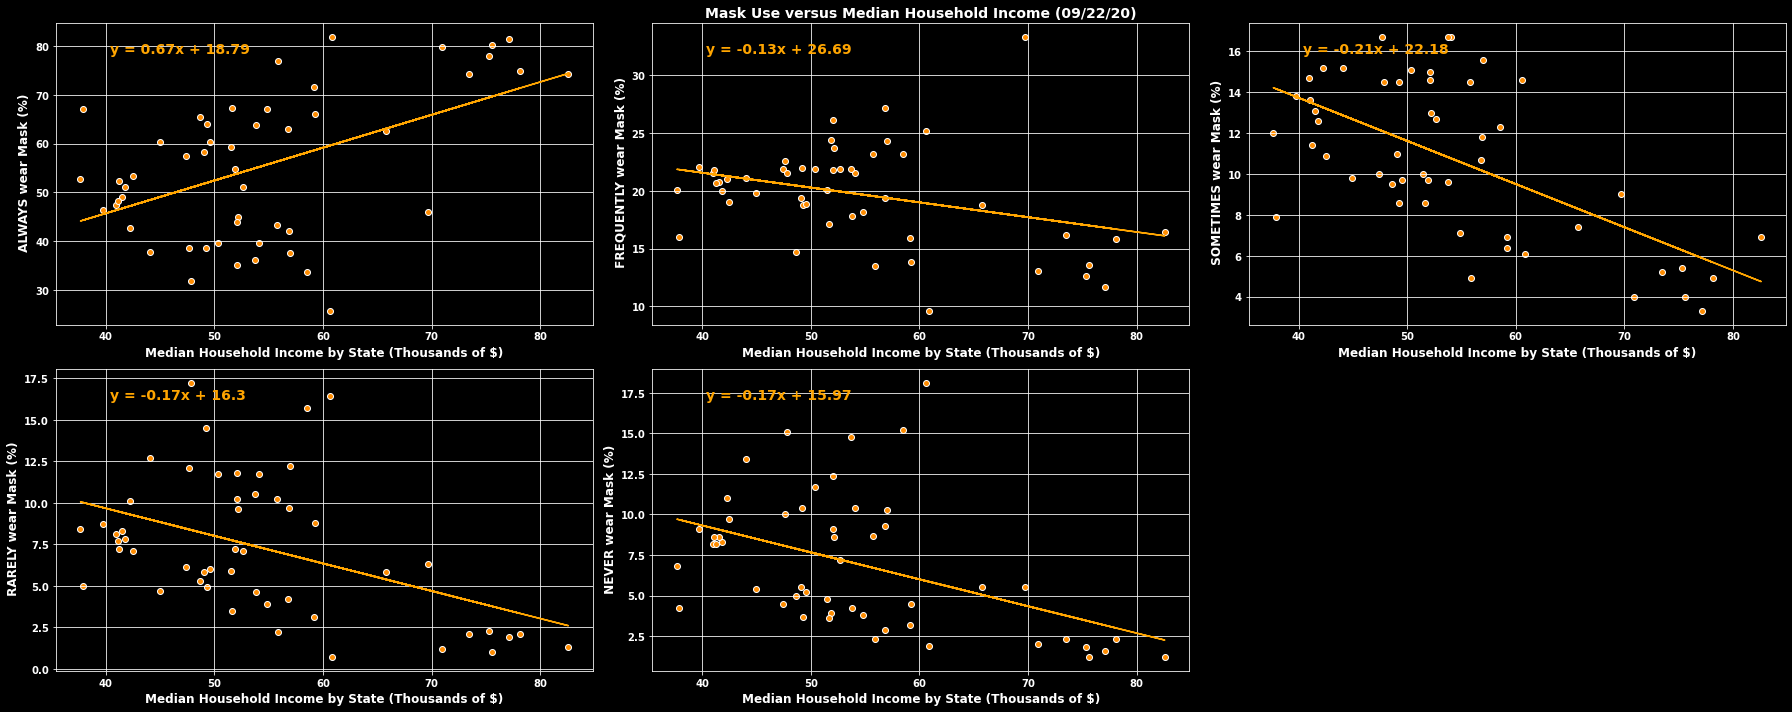

In [26]:
plt.style.use("dark_background")
color = "orange"
plt.figure(figsize=(25,10))
for i, c in enumerate(["ALWAYS", "FREQUENTLY", "SOMETIMES", "RARELY", "NEVER"]):
     
    
    plt.subplot(2, 3, i+1)
    x = df_merge["B19013_001E"]/1000
    y = df_merge[c] * 100 
    
    plt.scatter(x, y, linewidths=1, marker="o", facecolors="darkorange", edgecolors="white")
    if i==1:
        plt.title("Mask Use versus Median Household Income (%s)" % time.strftime("%x"),fontsize=14, weight='bold')
    plt.xlabel("Median Household Income by State (Thousands of $)",fontsize=12, weight='bold')
    plt.ylabel(" "+c+" wear Mask (%)",fontsize=12, weight='bold')
    plt.xticks(fontsize=10, weight='bold')
    plt.yticks(fontsize=10, weight='bold')
    plt.grid(True)
    slope, intercept, r_value, p_value, stderr=sts.linregress(x, y)
    plt.plot(x, slope*x+intercept, color)
    line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
    
    print(f"{c}")
    print(f"The correlation coefficient (r) is {round(r_value,2)}")
    print(f"The p-value is {round(p_value,6)}")
    print(f"The r-squared is {round(r_value**2, 2)}")
    
    plt.annotate(line_eq, (0.1, 0.9), fontsize=14, weight='bold', color=color, xycoords= "axes fraction")
    
plt.tight_layout()
outfile = os.path.join("Output", 'Covid19_MaskUsage_Income_Transparent.png')
plt.savefig(outfile, transparent=True)


#### 